In [1]:
import pandas as pd

In [2]:
datafile = "../data/rho_c/consistency.xlsx"

In [8]:
odf = pd.read_excel(datafile)
print(odf.head())

              name     l    w  area                  comment       R      rho  \
0  pSi_r48_400C_Ag  1.05  1.0  1.05  copper even counterflow  0.0859   90.195   
1  pSi_r48_400C_Ag  1.05  1.0  1.05                      NaN  0.0878   92.190   
2  pSi_r48_400C_Ag  1.05  1.0  1.05                      NaN  0.0904   94.920   
3  pSi_r48_400C_Ag  1.05  1.0  1.05                      NaN  0.0906   95.130   
4  pSi_r48_400C_Ag  1.05  1.0  1.05                      NaN  0.0954  100.170   

  orientation piece  
0        long     A  
1        long     A  
2        long     A  
3        long     A  
4        long     A  


In [4]:
from copy import deepcopy

def functional(fn):
    """ decorator that just runs a function on copies of inputs, overkill solution to treat inputs as immutable """
    def wrapper(*args, **kwargs):
        return fn(*deepcopy(args), **deepcopy(kwargs))
    return wrapper

@functional
def split_name(df):
    df[['substrate','doping','anneal','Ag']] = df.name.str.split('_',expand = True)
    df = df.drop(['name', 'Ag'], axis = 1)
    return df

@functional
def make_label(df):
    df['label'] = df.substrate.str.cat(others = df.anneal, sep = ' ')
    return df

@functional
def filter_multiple_orientations(df):
    """HARDCODED!!"""
    valids = [
        0.585, 
        0.26,
    ]
    return df[df.area.map(lambda x: x in valids)]
    
    
df_consistency = (odf
      .pipe(split_name)
      .pipe(make_label)
      .pipe(filter_multiple_orientations)
     )

    

       l     w   area                  comment       R      rho orientation  \
5   0.40  0.65  0.260  copper even counterflow  0.2590  67.3400       short   
6   0.40  0.65  0.260                      NaN  0.2890  75.1400       short   
7   0.40  0.65  0.260                      NaN  0.2697  70.1220       short   
8   0.40  0.65  0.260                      NaN  0.2617  68.0420       short   
9   0.40  0.65  0.260                      NaN  0.2796  72.6960       short   
10  0.40  0.65  0.260                      NaN  0.3021  78.5460        long   
11  0.40  0.65  0.260                      NaN  0.2650  68.9000        long   
12  0.40  0.65  0.260                      NaN  0.2650  68.9000        long   
13  0.40  0.65  0.260                      NaN  0.2760  71.7600        long   
14  0.40  0.65  0.260                      NaN  0.2910  75.6600        long   
40  0.65  0.90  0.585                      NaN  0.1270  74.2950        long   
41  0.65  0.90  0.585                      NaN  0.09

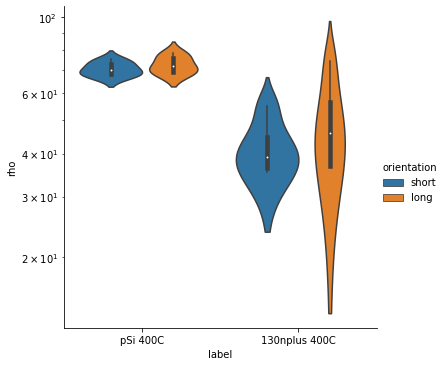

In [5]:
if __name__ == "__main__":
    import seaborn as sns
    from matplotlib import pyplot as plt
    p = sns.catplot(
        data = (odf
                .pipe(split_name)
                .pipe(make_label)
                .pipe(filter_multiple_orientations)
               ),
        x = 'label',
        y = 'rho',
        hue = 'orientation',
        kind = 'violin',
        #col = 'label',
    )
    p.set(yscale = 'log')
    plt.show()
    

    

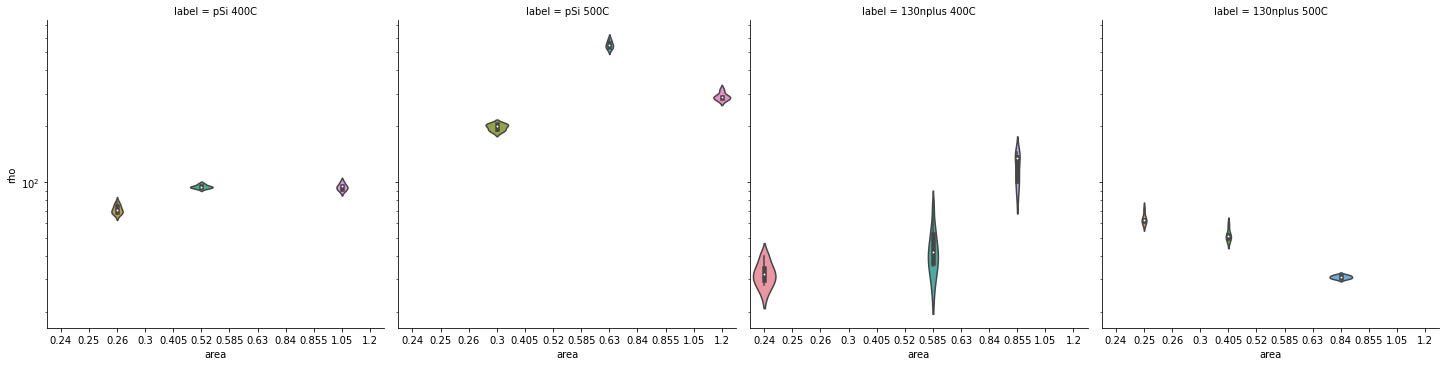

In [6]:
df_consistency = (odf
                .pipe(split_name)
                .pipe(make_label)
               )

if __name__ == "__main__":
    import seaborn as sns
    from matplotlib import pyplot as plt
    p = sns.catplot(
        data = (odf
                .pipe(split_name)
                .pipe(make_label)
               ),
        x = 'area',
        y = 'rho',
        #hue = 'area',
        kind = 'violin',
        col = 'label',
    )
    p.set(yscale = 'log')
    plt.show()
    


In [7]:
CBKR = pd.read_excel("../data/rho_c/CBKR_comparison.xlsx")

@functional
def make_label_CBKR(df):
    df['label'] = df.substrate.str.cat(others = [df.anneal, df.piece.astype(str)], sep = ' ')
    return df

df = (CBKR
      .rename({'Sample' : 'name'}, axis = 'columns')
      .pipe(split_name)
      .pipe(make_label_CBKR)
      .groupby(['label', 'type'])
      .rho
      .describe()
)


[Text(0.5, 0, 'PCB [m$\\Omega$cm$^2$]'),
 Text(0, 0.5, 'CBKR [m$\\Omega$cm$^2$]'),
 Text(0.5, 1.0, 'PCB vs CBKR measurements')]

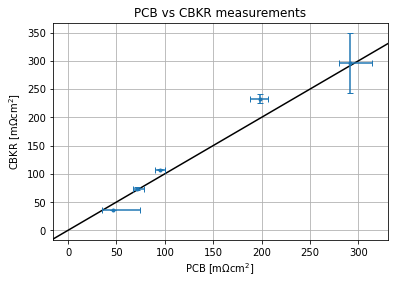

In [77]:
pdf = (df
       .unstack()  
      )

@functional
def get_plotvals(df, m_type = 'CBKR'):
    ret = (df
           .unstack()
           .xs(m_type, level = 1, axis= 1)
           .assign(
               min_err = lambda df: df['mean'] - df['min'],
               max_err = lambda df: df['max'] - df['mean'],
           )
          )
    return ret

PCB_plot  = get_plotvals(df, m_type = 'PCB')
CBKR_plot = get_plotvals(df, m_type = 'CBKR')

if __name__ == "__main__":
    from matplotlib import pyplot as plt

    plt.axline(
        (0,0), 
        slope = 1,
        color = 'k',
    )

    plt.errorbar(
        x =  PCB_plot['mean'], 
        xerr = PCB_plot[['min_err','max_err']].values.T,
        y = CBKR_plot['mean'],
        yerr = CBKR_plot[['min_err','max_err']].values.T,
        fmt = '.',
        capsize = 3,
    )

    plt.grid()

    plt.gca().set(
        xlabel = 'PCB [m$\\Omega$cm$^2$]',
        ylabel = 'CBKR [m$\\Omega$cm$^2$]',
        title = 'PCB vs CBKR measurements',
    )

In [43]:
pdf[('max','PCB')] - pdf[('mean','PCB')]

label
130nplus 400C 1    28.2438
pSi 400C 1          5.6490
pSi 400C 2          6.8354
pSi 500C 1         23.2800
pSi 500C 2          7.5600
dtype: float64

In [76]:
df

count        mean        std         min         25%  \
label           type                                                         
130nplus 400C 1 CBKR    2.0   35.923417   0.821069   35.342833   35.633125   
                PCB    10.0   46.051200  12.554178   35.392500   36.694125   
pSi 400C 1      CBKR    2.0  107.273250   1.239912  106.396500  106.834875   
                PCB     5.0   94.521000   3.761287   90.195000   92.190000   
pSi 400C 2      CBKR    4.0   73.427445   2.720541   71.044220   71.085170   
                PCB    10.0   71.710600   3.740738   67.340000   68.900000   
pSi 500C 1      CBKR    2.0  296.106600  75.991634  242.372400  269.239500   
                PCB     5.0  291.120000  13.539276  279.600000  284.400000   
pSi 500C 2      CBKR    2.0  233.257050  12.248716  224.595900  228.926475   
                PCB     5.0  198.540000   7.872928  188.400000  192.300000   

                             50%         75%        max  
label           type                                     
130nplus 400C 1 CBKR   35.923417   36.213708   36.50400  
                PCB    41.856750   52.737750   74.29500  
pSi 400C 1      CBKR  107.273250  107.711625  108.15000  
                PCB    94.920000   95.130000  100.17000  
pSi 400C 2      CBKR   73.429850   75.772125   75.80586  
                PCB    70.941000   74.529000   78.54600  
pSi 500C 1      CBKR  296.106600  322.973700  349.84080  
                PCB   288.000000  289.200000  314.40000  
pSi 500C 2      CBKR  233.257050  237.587625  241.91820  
                PCB   200.700000  205.200000  206.10000

In [63]:
df.unstack().xs('CBKR', level = 1, axis= 1).assign(min_err = lambda df: df['mean'] - df['min'])

,count,mean,std,min,25%,50%,75%,max,min_err
label,,,,,,,,,
130nplus 400C 1,2.0,35.923417,0.821069,35.342833,35.633125,35.923417,36.213708,36.50400,0.580583
pSi 400C 1,2.0,107.273250,1.239912,106.396500,106.834875,107.273250,107.711625,108.15000,0.876750
pSi 400C 2,4.0,73.427445,2.720541,71.044220,71.085170,73.429850,75.772125,75.80586,2.383225
pSi 500C 1,2.0,296.106600,75.991634,242.372400,269.239500,296.106600,322.973700,349.84080,53.734200
pSi 500C 2,2.0,233.257050,12.248716,224.595900,228.926475,233.257050,237.587625,241.91820,8.661150


In [72]:
df

count        mean        std         min         25%  \
label           type                                                         
130nplus 400C 1 CBKR    2.0   35.923417   0.821069   35.342833   35.633125   
                PCB    10.0   46.051200  12.554178   35.392500   36.694125   
pSi 400C 1      CBKR    2.0  107.273250   1.239912  106.396500  106.834875   
                PCB     5.0   94.521000   3.761287   90.195000   92.190000   
pSi 400C 2      CBKR    4.0   73.427445   2.720541   71.044220   71.085170   
                PCB    10.0   71.710600   3.740738   67.340000   68.900000   
pSi 500C 1      CBKR    2.0  296.106600  75.991634  242.372400  269.239500   
                PCB     5.0  291.120000  13.539276  279.600000  284.400000   
pSi 500C 2      CBKR    2.0  233.257050  12.248716  224.595900  228.926475   
                PCB     5.0  198.540000   7.872928  188.400000  192.300000   

                             50%         75%        max  
label           type                                     
130nplus 400C 1 CBKR   35.923417   36.213708   36.50400  
                PCB    41.856750   52.737750   74.29500  
pSi 400C 1      CBKR  107.273250  107.711625  108.15000  
                PCB    94.920000   95.130000  100.17000  
pSi 400C 2      CBKR   73.429850   75.772125   75.80586  
                PCB    70.941000   74.529000   78.54600  
pSi 500C 1      CBKR  296.106600  322.973700  349.84080  
                PCB   288.000000  289.200000  314.40000  
pSi 500C 2      CBKR  233.257050  237.587625  241.91820  
                PCB   200.700000  205.200000  206.10000